TODO Complete other stuff from the 01 notebook (such as submission to hugging face portal)

In [1]:
# Forcefully remove the old 'gym' package to avoid conflicts in Colab
%pip uninstall -y gym
%pip install -qr https://raw.githubusercontent.com/anton-dergunov/hugging-face-deep-rl/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter

# TODO Remove these imports and package dependencies
from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login

from huggingface_hub import HfApi, create_repo
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
import os
import json
import shutil

In [3]:
import warnings

# This filter handles the "pkg_resources is deprecated" warning from Pygame
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pygame')
warnings.filterwarnings("ignore", category=UserWarning, module="pygame")

# This filter handles all the "Deprecated call to `pkg_resources.declare_namespace`" warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pkg_resources')

In [27]:
MODEL_PATH = "models/ppo_cartpole"
VIDEO_PATH = "videos/cartpole_demo.mp4"
LOGS_PATH = "logs/ppo_cartpole"

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

In [64]:
ENV_ID = "CartPole-v1"

### Create Environment

TODO Describe the environment

In [ ]:
# Create a vectorized environment (parallel environments)
# "CartPole-v1" is a simple classic control task
# n_envs=4 means we run 4 copies of the environment in parallel
vec_env = make_vec_env(ENV_ID, n_envs=4)

### Define & Train PPO Agent

[PPO Algorithm](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

Training statistics:

- `rollout`:
    - `ep_len_mean`: Average episode length (steps before pole falls)
    - `ep_len_mean`: Average reward (same as length here)
- `time`:
    - `fps`: Training speed (frames per second)
    - `iterations`: Number of iterations?
    - `time_elapsed`: Time in seconds since the beginning of training
    - `total_timesteps`: Total number of timesteps. PPO collects in chunks of 8192 timesteps (with 4 envs × ~2048 steps)
- `train`:
    - `approx_kl`: KL divergence between new and old policy
    - `clip_fraction`: % of updates where PPO clipped gradients
    - `clip_range`: Value of clipping factor?
    - `entropy_loss`: Policy entropy (exploration). Lower → more deterministic.
    - `explained_variance`: How well value function predicts returns. 1 = perfect
    - `learning_rate`: Current learning rate value
    - `loss`: Current total loss value
    - `n_updates`: Number of gradient updates applied so far?
    - `policy_gradient_loss`: Current value of the policy gradient loss (its value does not have much meaning)
    - `value_loss`: Current value for the value function loss

Details: [Explanation of logger output](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#explanation-of-logger-output)

In [29]:
# Create vectorized env (n_envs=4) and wrap with VecMonitor to save monitor.csv
vec_env = VecMonitor(vec_env, filename=os.path.join(LOGS_PATH, "monitor.csv"))

# Initialize PPO model with TensorBoard logging
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    device="cpu",
    tensorboard_log=LOGS_PATH   # TensorBoard will write here
)

# Train the agent
model.learn(total_timesteps=25_000)

# Save the trained model
model.save(MODEL_PATH)

Using cpu device
Logging to logs/ppo_cartpole/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 21       |
| time/              |          |
|    fps             | 19080    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.2        |
|    ep_rew_mean          | 32.2        |
| time/                   |             |
|    fps                  | 7722        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013675597 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_varia

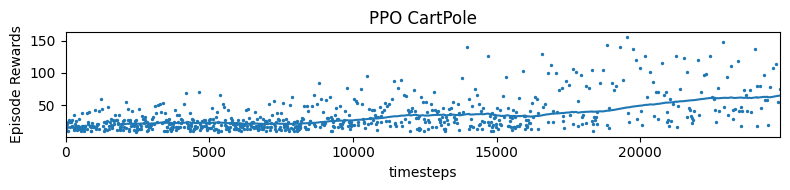

In [30]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH], 25_000, results_plotter.X_TIMESTEPS, "PPO CartPole")
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ppo_cartpole

### Load Trained Model

In [ ]:
# Load the saved model
model = PPO.load(MODEL_PATH, device="cpu")

### Evaluate Policy

In [84]:
def evaluate_model(model, env_id, n_eval_episodes=10):
    env = Monitor(gym.make(env_id))
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
    env.close()
    return {
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "n_eval_episodes": n_eval_episodes
    }

In [85]:
metrics = evaluate_model(model, ENV_ID)
print(metrics)

{'mean_reward': np.float64(372.0), 'std_reward': np.float64(90.82620767157462), 'n_eval_episodes': 10}


### Run Trained Agent

In [ ]:
def record_cartpole_video(model, video_path, steps=1000):
    # Set the video driver to a dummy one to prevent window creation
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    
    # Create env with video recording enabled
    env = gym.make(ENV_ID, render_mode="rgb_array")
    
    try:
        frames = []
        obs, info = env.reset()
        episode, step = 0, 0

        for _ in range(steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            
            # Render the frame from the environment
            frame = env.render()

            # --- Overlay text (small, anti-aliased) ---
            cv2.putText(frame, f"Ep: {episode}", (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(frame, f"Step: {step}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            frames.append(frame)
            step += 1

            if terminated or truncated:
                episode += 1
                step = 0
                obs, info = env.reset()
        
        # Save the collected frames to a single video file
        os.makedirs(os.path.dirname(video_path), exist_ok=True)
        imageio.mimsave(video_path, frames, fps=30, macro_block_size=None)
        print(f"Saved video to {video_path}")

    finally:
        # Ensure the environment is closed to release all resources
        env.close()

In [ ]:
# Save to video
record_cartpole_video(model, video_path=VIDEO_PATH, steps=1000)

Saved video to videos/cartpole_demo.mp4


In [10]:
Video(VIDEO_PATH, embed=True)

### Hugging Face: Store Credentials

To create and manage tokens:
https://huggingface.co/settings/tokens

Make sure to use the token with write role!

In [35]:
# Store Hugging Face token
notebook_login()

# Remember login credentials on disk
!git config --global credential.helper store

### Hugging Face: Upload the Model

In [80]:
def generate_readme(repo_name, env_id, algo, metrics, video_path=None):
    yaml_metadata = f"""---
library_name: stable-baselines3
tags:
- reinforcement-learning
- deep-reinforcement-learning
- sb3
- {env_id}
model-index:
- name: {repo_name}
  results:
  - task:
      type: reinforcement-learning
      name: Reinforcement Learning
    dataset:
      name: {env_id}
      type: gym
    metrics:
    - type: mean_reward
      value: {metrics['mean_reward']:.2f}
      name: Mean Reward
    - type: std_reward
      value: {metrics['std_reward']:.2f}
      name: Std Reward
---
"""
    video_block = f"\n## Demo Video\n\n![Demo]({video_path})\n" if video_path else ""

    readme = f"""{yaml_metadata}

# {repo_name}

This is a reinforcement learning agent trained with **{algo}** on **{env_id}** using [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3).

## Usage

```python
from huggingface_sb3 import load_from_hub

model = load_from_hub("{repo_name}")
obs = model.get_env().reset()

for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, info = model.get_env().step(action)
    if done:
        obs = model.get_env().reset()
```

## Evaluation Results

Mean reward (over {metrics['n_eval_episodes']} episodes): {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}

{video_block}
"""

    return readme

In [ ]:
def upload_sb3_model(model, repo_id, env_id, algo, metrics, video_path=None):
    api = HfApi()
    tmpdir = Path("hf_upload")
    tmpdir.mkdir(exist_ok=True)

    # 2. Save model
    model_path = tmpdir / "model"
    model.save(model_path)

    # 3. Save metadata.json
    metadata = {
        "model_name": repo_id.split("/")[-1],
        "model_architecture": algo,
        "env_id": env_id
    }
    with open(tmpdir / "metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)

    # 4. Save README.md with YAML + metrics + video
    video_url = f"videos/{Path(video_path).name}" if video_path else None
    readme_text = generate_readme(repo_id, env_id, algo, metrics, video_path=video_url)
    with open(tmpdir / "README.md", "w") as f:
        f.write(readme_text)

    # 5. Create repo if missing
    try:
        create_repo(repo_id, exist_ok=True)
    except Exception as e:
        print(f"⚠ Repo already exists or could not be created: {e}")

    # 6. Upload all files
    for file in tmpdir.iterdir():
        api.upload_file(
            path_or_fileobj=file,
            path_in_repo=file.name,
            repo_id=repo_id,
            commit_message=f"Add {file.name}"
        )

    # 7. Upload video separately
    if video_path:
        api.upload_file(
            path_or_fileobj=video_path,
            path_in_repo=f"videos/{Path(video_path).name}",
            repo_id=repo_id,
            commit_message="Add demo video"
        )

    # 8. Cleanup
    shutil.rmtree(tmpdir)
    print(f"Model, metadata, card and video uploaded to https://huggingface.co/{repo_id}")

In [83]:
upload_sb3_model(
    model=model,
    repo_id="AntonDergunov/CartPole_PPO",
    env_id="CartPole-v1",
    algo="PPO",
    metrics=metrics,
    video_path=VIDEO_PATH
)

No files have been modified since last commit. Skipping to prevent empty commit.
Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

Processing Files (1 / 1)                : 100%|██████████|  138kB /  138kB, 98.5kB/s  

Processing Files (1 / 1)                : 100%|██████████|  138kB /  138kB, 86.2kB/s  
New Data Upload                         : 100%|██████████|  138kB /  138kB, 86.2kB/s  
  hf_upload/model.zip                   : 100%|██████████|  138kB /  138kB            
Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

Processing Files (1 / 1)                : 100%|██████████|  119kB /  119kB,   ???B/s  

Processing Files (1 / 1)                : 100%|██████████|  119kB /  119kB,  0.00B/s  
New Data Upload                         : |          |  0.00B /  0.00B,  0.00B/s  
  videos/cartpole_demo.mp4              : 100%|██████████|  119kB /  119kB            
No files have been modified since last commit. Skipping t

Model, metadata, card and video uploaded to AntonDergunov/CartPole_PPO
